# Task 0b - Normalization
This notebook does normalization of the data. This is the second step and requires the adata from the first step, Task 0a - QC.

This notebook is based on the single-cell tutorial (https://github.com/theislab/single-cell-tutorial). For further explanations of the applied methods please refer to above source.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
# from gprofiler import GProfiler
from os import listdir
from os.path import isfile, join

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
anndata2ri                  0.0.0
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.1
colorama                    0.4.6
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.3
decorator                   5.1.1
defusedxml                  0.7.1
dunamai                     1.14.0
entrypoints                 0.4
future_fstrings             NA
get_version                 3.5.4
google                      NA
h5py                        3.7.0
igraph                      0.9.11
ipykernel                   6.16.2
ipython_genutils            0.2.0
jedi                        0.18.1
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.8.10
llvmlite     

In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)


Error in library(slingshot) : there is no package called ‘slingshot’


### IMPORT ADATA OF QC

In [4]:
adata = sc.read_h5ad('../data/adata/QC_adata.h5ad')

## Normalization

In [5]:
# Clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/icb/till.richter/anaconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:09)


In [6]:
# Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [7]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [8]:
# Delete adata_pp
del adata_pp

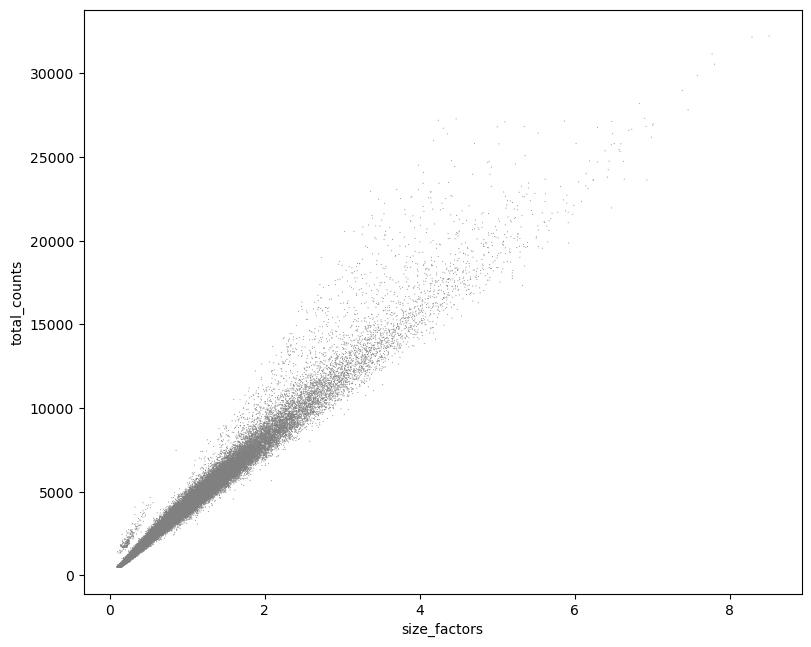

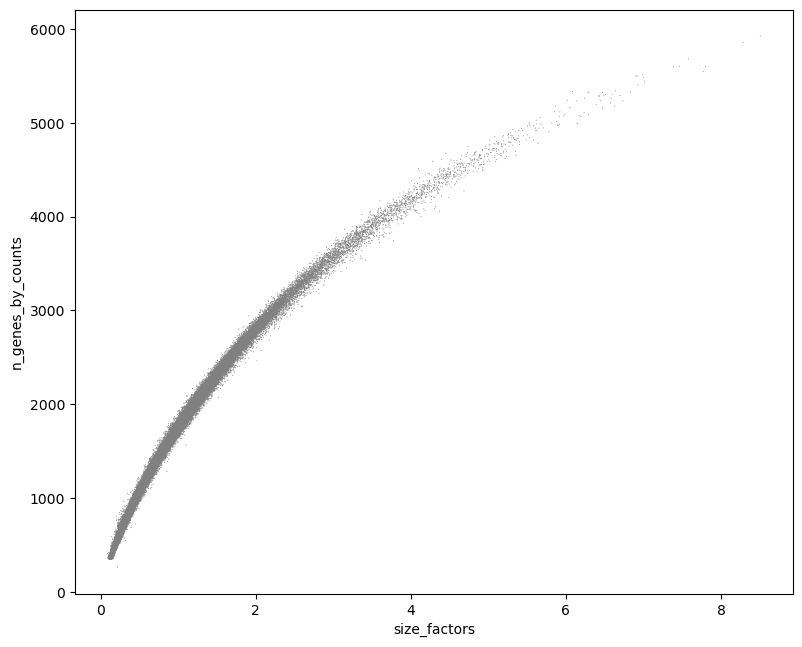

/home/icb/till.richter/anaconda3/envs/scib-pipeline-R4.0/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


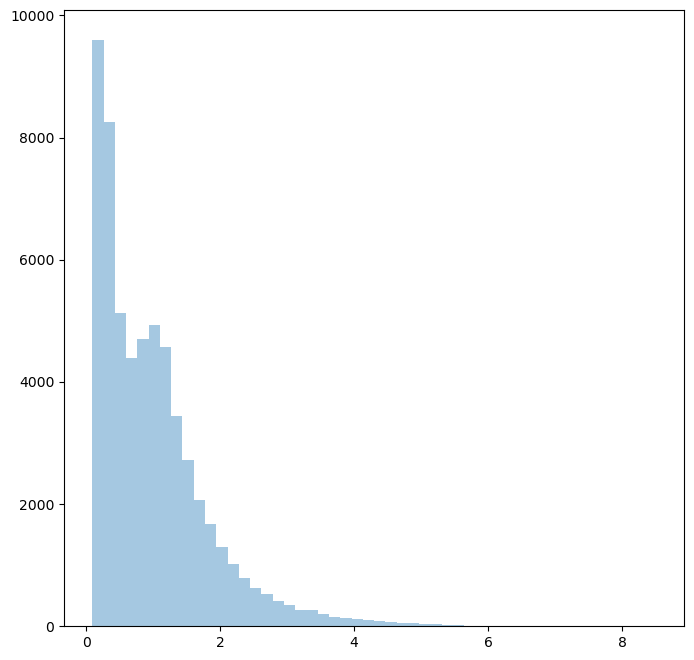

In [9]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [10]:
# Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
adata.X = sp.sparse.csr_matrix(adata.X)
sc.pp.log1p(adata)

In [12]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

In [13]:
adata.write_h5ad('../data/adata/norm_adata.h5ad')